In [1]:
# !pip install gym==0.17.3
# !pip install optuna

In [2]:
import numpy as np
import gym
from tqdm.notebook import trange
import random
import optuna
import matplotlib.pyplot as plt
import itertools

from blackjack_double import BlackjackDoubleEnv
from blackjack_counting import BlackjackCountingEnv

In [3]:
N_EPISODS = 10**5

# Часть первая, с блекджеком и стратегиями

#### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [4]:
def make_blackjack_env():
    env = gym.make("Blackjack-v0", natural=True)
    return env

In [5]:
def play_blackjack_simple_strategy():
    env = make_blackjack_env()
    init = True
    done = False
    while not done:
        if init:
            observation = env.reset()
            init = False
            continue
        player_score, _, _ = observation
        action = 0 if player_score in (19, 20, 21) else 1
        observation, reward, done, _ = env.step(action)
    env.close()
    return reward

In [6]:
def monte_carlo_reward(play_blackjack, n_episods=N_EPISODS, tqdm_disable=False, *args, **kwargs):
    total_rewards = 0
    for _ in trange(n_episods, disable=tqdm_disable):
         total_rewards += play_blackjack(*args, **kwargs)
    return total_rewards / n_episods

In [7]:
monte_carlo_reward(play_blackjack_simple_strategy)

  0%|          | 0/100000 [00:00<?, ?it/s]

-0.17847

#### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [8]:
def collect_states(make_blackjack, n_episods=N_EPISODS):
    all_states = set()
    for _ in trange(n_episods):
        env = make_blackjack()
        init = True
        done = False
        while not done:
            if init:
                observation = env.reset()
                all_states.add(observation)
                init = False
                continue
            action = np.random.randint(0, 2)
            observation, _, done, _ = env.step(action)
            all_states.add(observation)
        env.close()
    return list(all_states)

In [9]:
A = (0, 1)
S = collect_states(make_blackjack_env)

a_to_idx = {a: i for i, a in enumerate(A)}
idx_to_a = {i: a for i, a in enumerate(A)}
s_to_idx = {s: i for i, s in enumerate(S)}
idx_to_s = {i: s for i, s in enumerate(S)}

  0%|          | 0/100000 [00:00<?, ?it/s]

In [10]:
def Q_learn(alpha=0.01, epsilon=0.9, n_episods=N_EPISODS, *args, **kwargs):
    Q = np.zeros((len(S), len(A)))
    
    for _ in trange(n_episods, *args, **kwargs):
        init = True
        done = False
        while not done:
            if init:
                env = make_blackjack_env()
                observation = env.reset()
                s_idx = s_to_idx[observation]
                init = False
                continue
        
            if random.random() < epsilon:
                a_idx = np.random.choice(list(a_to_idx))
            else:
                a_idx = np.argmax(Q[s_idx])
            
            observation, reward, done, _ = env.step(idx_to_a[a_idx])
            s_next_idx = s_to_idx[observation]
            Q[s_idx, a_idx] += alpha * (reward + np.max(Q[s_next_idx]) - Q[s_idx, a_idx])
            s_idx = s_next_idx
        env.close()
    
    return Q

In [11]:
def play_blackjack_qlearning(Q):
    env = make_blackjack_env()
    init = True
    done = False
    while not done:
        if init:
            observation = env.reset()
            init = False
            continue
        s_idx = s_to_idx[observation]
        a_idx = np.argmax(Q[s_idx])
        observation, reward, done, _ = env.step(idx_to_a[a_idx])
    env.close()
    return reward

In [12]:
Q = Q_learn()

  0%|          | 0/100000 [00:00<?, ?it/s]

In [13]:
monte_carlo_reward(play_blackjack_qlearning, Q=Q)

  0%|          | 0/100000 [00:00<?, ?it/s]

-0.118345

#### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [14]:
def optimized_reward(trial):
    epsilon = trial.suggest_uniform("epsilon", 0, 1)
    alpha = trial.suggest_uniform("alpha", 0, 1)
    Q = Q_learn(epsilon=epsilon, alpha=alpha, n_episods=100000, leave=False)
    return monte_carlo_reward(play_blackjack_qlearning, n_episods=10**4, tqdm_disable=True, Q=Q)

In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(optimized_reward, n_trials=100)

[I 2021-10-19 02:32:15,546] A new study created in memory with name: no-name-56812319-140f-4c9d-ae5b-619b3832d905


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:32:55,007] Trial 0 finished with value: -0.16215 and parameters: {'epsilon': 0.30402971331574125, 'alpha': 0.6745181387040777}. Best is trial 0 with value: -0.16215.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:33:35,317] Trial 1 finished with value: -0.161 and parameters: {'epsilon': 0.823897843397656, 'alpha': 0.7953558871517414}. Best is trial 1 with value: -0.161.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:34:15,719] Trial 2 finished with value: -0.1198 and parameters: {'epsilon': 0.3827497426701487, 'alpha': 0.15894202986692274}. Best is trial 2 with value: -0.1198.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:34:57,321] Trial 3 finished with value: -0.14005 and parameters: {'epsilon': 0.3113548234660759, 'alpha': 0.7848271639476925}. Best is trial 2 with value: -0.1198.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:35:38,920] Trial 4 finished with value: -0.07525 and parameters: {'epsilon': 0.8694493259835477, 'alpha': 0.06213612686071135}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:36:20,604] Trial 5 finished with value: -0.15045 and parameters: {'epsilon': 0.7847211362834153, 'alpha': 0.6209252298701743}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:37:01,705] Trial 6 finished with value: -0.13295 and parameters: {'epsilon': 0.2843523359645812, 'alpha': 0.2863242103369833}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:37:41,694] Trial 7 finished with value: -0.14825 and parameters: {'epsilon': 0.5136999066279766, 'alpha': 0.8361310607149997}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:38:21,457] Trial 8 finished with value: -0.14045 and parameters: {'epsilon': 0.06716968238840992, 'alpha': 0.5402335278990752}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:39:01,560] Trial 9 finished with value: -0.12135 and parameters: {'epsilon': 0.14115951801520132, 'alpha': 0.23048346667003838}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:39:42,666] Trial 10 finished with value: -0.1532 and parameters: {'epsilon': 0.9959069554154476, 'alpha': 0.008778752606165938}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:40:23,275] Trial 11 finished with value: -0.1253 and parameters: {'epsilon': 0.5646388099295627, 'alpha': 0.008168987285818281}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:41:03,746] Trial 12 finished with value: -0.13005 and parameters: {'epsilon': 0.6927396743019298, 'alpha': 0.25564528755498783}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:41:44,543] Trial 13 finished with value: -0.1463 and parameters: {'epsilon': 0.9694793100940554, 'alpha': 0.37409220289782297}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:42:25,920] Trial 14 finished with value: -0.11515 and parameters: {'epsilon': 0.39018597871404626, 'alpha': 0.1326656890404252}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:43:06,455] Trial 15 finished with value: -0.1419 and parameters: {'epsilon': 0.6760184997101614, 'alpha': 0.41330473487929986}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:43:47,283] Trial 16 finished with value: -0.10415 and parameters: {'epsilon': 0.586197094652105, 'alpha': 0.11806943990695733}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:44:28,037] Trial 17 finished with value: -0.1588 and parameters: {'epsilon': 0.8691811566405256, 'alpha': 0.9513490183618819}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:45:08,630] Trial 18 finished with value: -0.13585 and parameters: {'epsilon': 0.5914007892293078, 'alpha': 0.13774900840422122}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:45:48,860] Trial 19 finished with value: -0.13555 and parameters: {'epsilon': 0.6969513298379945, 'alpha': 0.40484547075021915}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:46:29,388] Trial 20 finished with value: -0.11075 and parameters: {'epsilon': 0.895257292293203, 'alpha': 0.08131524350450528}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:47:09,884] Trial 21 finished with value: -0.14845 and parameters: {'epsilon': 0.8950411252666667, 'alpha': 0.07497199814846567}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:47:50,263] Trial 22 finished with value: -0.11135 and parameters: {'epsilon': 0.7649343417061487, 'alpha': 0.09933812500758629}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:48:30,719] Trial 23 finished with value: -0.11535 and parameters: {'epsilon': 0.9461846013503543, 'alpha': 0.21018150661854093}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:49:10,868] Trial 24 finished with value: -0.1407 and parameters: {'epsilon': 0.6241080663465606, 'alpha': 0.3312254172942966}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:49:51,607] Trial 25 finished with value: -0.13265 and parameters: {'epsilon': 0.7484825838656235, 'alpha': 0.0648655118050315}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:50:31,999] Trial 26 finished with value: -0.1356 and parameters: {'epsilon': 0.8764832936530687, 'alpha': 0.19223358450354996}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:51:11,787] Trial 27 finished with value: -0.1705 and parameters: {'epsilon': 0.4496555004559676, 'alpha': 0.5191285093050964}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:51:52,705] Trial 28 finished with value: -0.1392 and parameters: {'epsilon': 0.840370207371496, 'alpha': 0.019233705838058113}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:52:33,123] Trial 29 finished with value: -0.13265 and parameters: {'epsilon': 0.9224474328765045, 'alpha': 0.3102984783499254}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:53:12,621] Trial 30 finished with value: -0.08385 and parameters: {'epsilon': 0.5172703140451302, 'alpha': 0.08439718490389181}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:53:51,918] Trial 31 finished with value: -0.0952 and parameters: {'epsilon': 0.5092156308263872, 'alpha': 0.09392731266059012}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:54:31,524] Trial 32 finished with value: -0.1404 and parameters: {'epsilon': 0.5156626889255771, 'alpha': 0.17682510988841663}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:55:10,964] Trial 33 finished with value: -0.1342 and parameters: {'epsilon': 0.47553534267970493, 'alpha': 0.12778741415200526}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:55:50,270] Trial 34 finished with value: -0.114 and parameters: {'epsilon': 0.4136648975470538, 'alpha': 0.07844766539789622}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:56:29,718] Trial 35 finished with value: -0.09485 and parameters: {'epsilon': 0.26624949262215714, 'alpha': 0.17793273818387997}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:57:08,745] Trial 36 finished with value: -0.1461 and parameters: {'epsilon': 0.23985886312836197, 'alpha': 0.24086004136464217}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:57:47,301] Trial 37 finished with value: -0.16565 and parameters: {'epsilon': 0.21747436330569792, 'alpha': 0.59222582565638}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:58:26,402] Trial 38 finished with value: -0.14585 and parameters: {'epsilon': 0.34024565131702017, 'alpha': 0.4537914962111642}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:59:06,158] Trial 39 finished with value: -0.1936 and parameters: {'epsilon': 0.0017441561278782602, 'alpha': 0.6780102768432847}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 02:59:45,993] Trial 40 finished with value: -0.10855 and parameters: {'epsilon': 0.12884653122736564, 'alpha': 0.17483982076917162}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:00:26,594] Trial 41 finished with value: -0.13525 and parameters: {'epsilon': 0.5431922702306504, 'alpha': 0.03265810737741775}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:01:06,517] Trial 42 finished with value: -0.1176 and parameters: {'epsilon': 0.45462216844757697, 'alpha': 0.1244575756689062}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:01:46,207] Trial 43 finished with value: -0.1427 and parameters: {'epsilon': 0.6092626003409898, 'alpha': 0.25460636465637343}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:02:26,467] Trial 44 finished with value: -0.11035 and parameters: {'epsilon': 0.3442435005053055, 'alpha': 0.055669477527863935}. Best is trial 4 with value: -0.07525.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:03:06,606] Trial 45 finished with value: -0.0616 and parameters: {'epsilon': 0.6524766434893651, 'alpha': 0.003410874135862385}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:03:46,375] Trial 46 finished with value: -0.13895 and parameters: {'epsilon': 0.6492959341627056, 'alpha': 0.02689314899422751}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:04:26,731] Trial 47 finished with value: -0.12565 and parameters: {'epsilon': 0.8156616040162165, 'alpha': 0.17868375106937384}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:05:06,388] Trial 48 finished with value: -0.13605 and parameters: {'epsilon': 0.5320190210441624, 'alpha': 0.004966800514287273}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:05:45,352] Trial 49 finished with value: -0.1305 and parameters: {'epsilon': 0.28482357979206613, 'alpha': 0.2810630639529075}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:06:25,014] Trial 50 finished with value: -0.1403 and parameters: {'epsilon': 0.41787392789591954, 'alpha': 0.14649302673710266}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:07:04,535] Trial 51 finished with value: -0.13715 and parameters: {'epsilon': 0.5726271175123789, 'alpha': 0.09530499659281078}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:07:44,035] Trial 52 finished with value: -0.1361 and parameters: {'epsilon': 0.7275500533784756, 'alpha': 0.1085995279207907}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:08:23,879] Trial 53 finished with value: -0.0832 and parameters: {'epsilon': 0.49228318598153686, 'alpha': 0.05181481051629931}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:09:03,665] Trial 54 finished with value: -0.13305 and parameters: {'epsilon': 0.4857005948397691, 'alpha': 0.045079901220330905}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:09:43,587] Trial 55 finished with value: -0.13575 and parameters: {'epsilon': 0.6506112674160266, 'alpha': 0.004052954524205468}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:10:22,756] Trial 56 finished with value: -0.16875 and parameters: {'epsilon': 0.3723635775122695, 'alpha': 0.21969814417667666}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:11:02,357] Trial 57 finished with value: -0.1432 and parameters: {'epsilon': 0.7988571695619872, 'alpha': 0.05276511856590708}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:11:40,973] Trial 58 finished with value: -0.1684 and parameters: {'epsilon': 0.20903364109825545, 'alpha': 0.9948171736342983}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:12:20,306] Trial 59 finished with value: -0.10985 and parameters: {'epsilon': 0.15921923487446915, 'alpha': 0.14373378279073581}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:12:59,321] Trial 60 finished with value: -0.14405 and parameters: {'epsilon': 0.5627774910695554, 'alpha': 0.7539230543550043}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:13:38,962] Trial 61 finished with value: -0.08305 and parameters: {'epsilon': 0.7231866061067149, 'alpha': 0.09981533837393206}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:14:18,634] Trial 62 finished with value: -0.12295 and parameters: {'epsilon': 0.7169283913691811, 'alpha': 0.09734586012096291}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:14:58,634] Trial 63 finished with value: -0.1128 and parameters: {'epsilon': 0.6605198822757847, 'alpha': 0.06312971726102551}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:15:38,246] Trial 64 finished with value: -0.1413 and parameters: {'epsilon': 0.7567460507394769, 'alpha': 0.20144660572905881}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:16:17,883] Trial 65 finished with value: -0.15855 and parameters: {'epsilon': 0.6991498749052025, 'alpha': 0.15382507482031477}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:16:57,791] Trial 66 finished with value: -0.0894 and parameters: {'epsilon': 0.9991403050862087, 'alpha': 0.09452226190151657}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:17:37,485] Trial 67 finished with value: -0.10745 and parameters: {'epsilon': 0.9592830303217053, 'alpha': 0.04457615822789023}. Best is trial 45 with value: -0.0616.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:18:17,312] Trial 68 finished with value: -0.04785 and parameters: {'epsilon': 0.9957643573726924, 'alpha': 0.0011736313992879305}. Best is trial 68 with value: -0.04785.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:18:57,285] Trial 69 finished with value: -0.0718 and parameters: {'epsilon': 0.9989011048387774, 'alpha': 0.0060014760251932905}. Best is trial 68 with value: -0.04785.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:19:37,306] Trial 70 finished with value: -0.1532 and parameters: {'epsilon': 0.933640316860952, 'alpha': 0.012021343612267157}. Best is trial 68 with value: -0.04785.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:20:16,903] Trial 71 finished with value: -0.14935 and parameters: {'epsilon': 0.9929728377965952, 'alpha': 0.03727760092147271}. Best is trial 68 with value: -0.04785.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:20:56,716] Trial 72 finished with value: -0.04455 and parameters: {'epsilon': 0.9959792526945, 'alpha': 0.0013746014784169233}. Best is trial 72 with value: -0.04455.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:21:36,565] Trial 73 finished with value: -0.1032 and parameters: {'epsilon': 0.9112733317710107, 'alpha': 0.0704922528796271}. Best is trial 72 with value: -0.04455.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:22:16,505] Trial 74 finished with value: -0.03055 and parameters: {'epsilon': 0.8853748597787027, 'alpha': 0.000567823342672265}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:22:56,634] Trial 75 finished with value: -0.07215 and parameters: {'epsilon': 0.85198213458211, 'alpha': 0.0032353900844728986}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:23:36,515] Trial 76 finished with value: -0.06245 and parameters: {'epsilon': 0.8456232942207117, 'alpha': 0.002519865859458181}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:24:16,468] Trial 77 finished with value: -0.13285 and parameters: {'epsilon': 0.8574298039470064, 'alpha': 0.005922884371216432}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:24:56,684] Trial 78 finished with value: -0.1314 and parameters: {'epsilon': 0.882815837115619, 'alpha': 0.024139911018746463}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:25:36,351] Trial 79 finished with value: -0.04185 and parameters: {'epsilon': 0.837834178795464, 'alpha': 0.00011415618002979085}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:26:16,189] Trial 80 finished with value: -0.0719 and parameters: {'epsilon': 0.974107457517317, 'alpha': 0.004056550282613203}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:26:56,108] Trial 81 finished with value: -0.14905 and parameters: {'epsilon': 0.9709708725948389, 'alpha': 0.02814551548605395}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:27:35,688] Trial 82 finished with value: -0.06545 and parameters: {'epsilon': 0.8385675099690356, 'alpha': 0.0028856742231872486}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:28:15,383] Trial 83 finished with value: -0.15265 and parameters: {'epsilon': 0.9204701081455671, 'alpha': 0.0718542822583221}. Best is trial 74 with value: -0.03055.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:28:55,423] Trial 84 finished with value: -0.0209 and parameters: {'epsilon': 0.9684817205319124, 'alpha': 0.0014975518853093716}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:29:35,632] Trial 85 finished with value: -0.12775 and parameters: {'epsilon': 0.9448635656773036, 'alpha': 0.04083215172900442}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:30:15,468] Trial 86 finished with value: -0.112 and parameters: {'epsilon': 0.8162086660930333, 'alpha': 0.032358581382938005}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:30:55,059] Trial 87 finished with value: -0.1068 and parameters: {'epsilon': 0.7884002737631125, 'alpha': 0.12630420516905552}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:31:34,678] Trial 88 finished with value: -0.15265 and parameters: {'epsilon': 0.8347734480651916, 'alpha': 0.8593465695458153}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:32:14,673] Trial 89 finished with value: -0.1086 and parameters: {'epsilon': 0.9033112095857796, 'alpha': 0.05391824539449946}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:32:54,221] Trial 90 finished with value: -0.098 and parameters: {'epsilon': 0.8820561611149351, 'alpha': 0.06825163453972842}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:33:33,917] Trial 91 finished with value: -0.0589 and parameters: {'epsilon': 0.9738677972282399, 'alpha': 0.0020140003904572847}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:34:13,895] Trial 92 finished with value: -0.0587 and parameters: {'epsilon': 0.9521490872232525, 'alpha': 0.0018632483146722805}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:34:53,833] Trial 93 finished with value: -0.1378 and parameters: {'epsilon': 0.9570484360799217, 'alpha': 0.03200033648571957}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:35:33,757] Trial 94 finished with value: -0.0549 and parameters: {'epsilon': 0.926118020424223, 'alpha': 0.0005898796159473387}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:36:13,619] Trial 95 finished with value: -0.09835 and parameters: {'epsilon': 0.9303530442682539, 'alpha': 0.07852482196150619}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:36:53,423] Trial 96 finished with value: -0.134 and parameters: {'epsilon': 0.9731543895006082, 'alpha': 0.025932465966893144}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:37:33,257] Trial 97 finished with value: -0.1297 and parameters: {'epsilon': 0.9012638453894274, 'alpha': 0.04511653472738577}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:38:13,006] Trial 98 finished with value: -0.08595 and parameters: {'epsilon': 0.8664453098633887, 'alpha': 0.10902762607432877}. Best is trial 84 with value: -0.0209.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 03:38:52,908] Trial 99 finished with value: -0.11505 and parameters: {'epsilon': 0.9454105072031985, 'alpha': 0.08005298281178601}. Best is trial 84 with value: -0.0209.


In [16]:
Q = Q_learn(alpha=study.best_params["alpha"], epsilon=study.best_params["epsilon"])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [17]:
monte_carlo_reward(play_blackjack_qlearning, Q=Q)

  0%|          | 0/100000 [00:00<?, ?it/s]

-0.029405

In [18]:
def Q_learn_plot(alpha=0.1, epsilon=0.05):
    Q = np.zeros((len(S), len(A)))
    n_episods = 15000
    avg_rewards = []
    for _ in trange(n_episods):
        init = True
        done = False
        while not done:
            if init:
                env = make_blackjack_env()
                observation = env.reset()
                s_idx = s_to_idx[observation]
                init = False
                continue
        
            if random.random() < epsilon:
                a_idx = np.random.choice(list(a_to_idx))
            else:
                a_idx = np.argmax(Q[s_idx])
            
            observation, reward, done, _ = env.step(idx_to_a[a_idx])
            s_next_idx = s_to_idx[observation]
            Q[s_idx, a_idx] += alpha * (reward + np.max(Q[s_next_idx]) - Q[s_idx, a_idx])
            s_idx = s_next_idx
        r = monte_carlo_reward(play_blackjack_qlearning, tqdm_disable=True, Q=Q, n_episods=3000)
        avg_rewards.append(r)
        env.close()
    
    plt.figure(figsize=(20, 10))
    plt.plot(range(1, n_episods + 1), avg_rewards)
    plt.title("Средний доход по ходу обучения")
    plt.show()

  0%|          | 0/15000 [00:00<?, ?it/s]

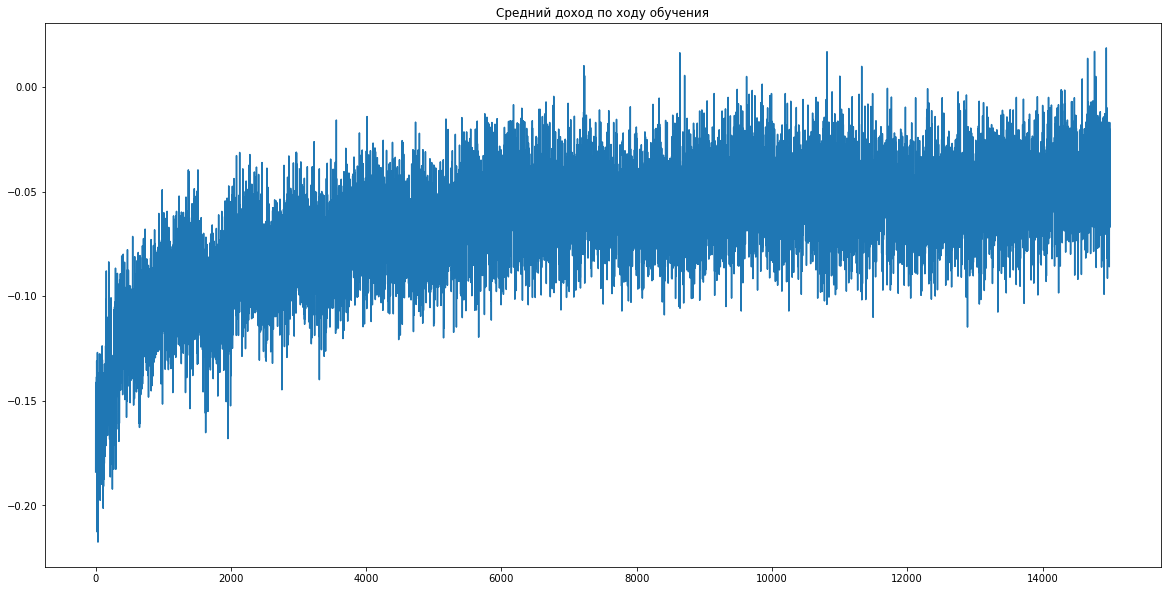

In [19]:
Q_learn_plot(alpha=study.best_params["alpha"], epsilon=study.best_params["epsilon"])

# Часть вторая, удвоенная

#### 5. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [41]:
def make_blackjack_double_env():
    env = BlackjackDoubleEnv(natural=True)
    return env

#### 6. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [42]:
A = (0, 1, 2)
S = collect_states(make_blackjack_env, n_episods=10**5)

a_to_idx = {a: i for i, a in enumerate(A)}
idx_to_a = {i: a for i, a in enumerate(A)}
s_to_idx = {s: i for i, s in enumerate(S)}
idx_to_s = {i: s for i, s in enumerate(S)}

  0%|          | 0/100000 [00:00<?, ?it/s]

In [43]:
def Q_learn_double(alpha=0.1, epsilon=0.05, n_episods=N_EPISODS, *args, **kwargs):
    Q = np.zeros((len(S), len(A)))
    
    for _ in trange(n_episods, *args, **kwargs):
        init = True
        done = False
        while not done:
            if init:
                env = make_blackjack_double_env()
                observation = env.reset()
                s_idx = s_to_idx[observation]
                init = False
                continue
        
            if random.random() < epsilon:
                a_idx = np.random.choice(list(a_to_idx))
            else:
                a_idx = np.argmax(Q[s_idx])
            
            observation, reward, done, _ = env.step(idx_to_a[a_idx])
            s_next_idx = s_to_idx[observation]
            Q[s_idx, a_idx] += alpha * (reward + np.max(Q[s_next_idx]) - Q[s_idx, a_idx])
            s_idx = s_next_idx
        env.close()
    
    return Q

In [24]:
Q = Q_learn_double(alpha=study.best_params["alpha"], epsilon=study.best_params["epsilon"])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [44]:
def play_blackjack_double_qlearning(Q):
    env = make_blackjack_double_env()
    init = True
    done = False
    while not done:
        if init:
            observation = env.reset()
            init = False
            continue
        s_idx = s_to_idx[observation]
        a_idx = np.argmax(Q[s_idx])
        observation, reward, done, _ = env.step(idx_to_a[a_idx])
    env.close()
    return reward

In [26]:
monte_carlo_reward(play_blackjack_double_qlearning, Q=Q)

  0%|          | 0/100000 [00:00<?, ?it/s]

-0.040525

In [47]:
def optimized_reward_double(trial):
    epsilon = trial.suggest_uniform("epsilon", 0.9, 1)
    alpha = trial.suggest_uniform("alpha", 0, 0.01)
    Q = Q_learn_double(epsilon=epsilon, alpha=alpha, n_episods=100000, leave=False)
    return monte_carlo_reward(play_blackjack_double_qlearning, n_episods=10**5, tqdm_disable=True, Q=Q)

In [48]:
study_double = optuna.create_study(direction="maximize")
study_double.optimize(optimized_reward_double, n_trials=100)

[I 2021-10-19 15:18:22,884] A new study created in memory with name: no-name-32c46d6b-4b92-4dbe-8720-bca55e417370


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:19:16,311] Trial 0 finished with value: -0.109685 and parameters: {'epsilon': 0.9209990653995525, 'alpha': 0.007910822968367778}. Best is trial 0 with value: -0.109685.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:20:08,655] Trial 1 finished with value: -0.077925 and parameters: {'epsilon': 0.9015279440664886, 'alpha': 0.0074342947577195305}. Best is trial 1 with value: -0.077925.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:21:04,031] Trial 2 finished with value: -0.088995 and parameters: {'epsilon': 0.9119685085300034, 'alpha': 0.005978187684209422}. Best is trial 1 with value: -0.077925.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:21:56,958] Trial 3 finished with value: -0.09047 and parameters: {'epsilon': 0.9369354014294993, 'alpha': 0.009732592118984945}. Best is trial 1 with value: -0.077925.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:22:52,135] Trial 4 finished with value: -0.03498 and parameters: {'epsilon': 0.9361600071958702, 'alpha': 0.0011596138609488182}. Best is trial 4 with value: -0.03498.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:23:49,237] Trial 5 finished with value: -0.065335 and parameters: {'epsilon': 0.9327158976833388, 'alpha': 0.006402252809165088}. Best is trial 4 with value: -0.03498.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:24:47,708] Trial 6 finished with value: -0.06097 and parameters: {'epsilon': 0.9739650547773753, 'alpha': 0.0056983494421985}. Best is trial 4 with value: -0.03498.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:25:42,691] Trial 7 finished with value: -0.051235 and parameters: {'epsilon': 0.9072652500799557, 'alpha': 0.005091554553326686}. Best is trial 4 with value: -0.03498.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:26:38,351] Trial 8 finished with value: -0.02535 and parameters: {'epsilon': 0.9129993483255061, 'alpha': 0.00017990698206746703}. Best is trial 8 with value: -0.02535.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:27:33,091] Trial 9 finished with value: -0.05165 and parameters: {'epsilon': 0.9845132080830041, 'alpha': 0.003791573547535582}. Best is trial 8 with value: -0.02535.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:28:28,099] Trial 10 finished with value: -0.01993 and parameters: {'epsilon': 0.9573044813454182, 'alpha': 7.937648688917517e-05}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:29:22,679] Trial 11 finished with value: -0.022135 and parameters: {'epsilon': 0.959570856223416, 'alpha': 6.851625668736828e-05}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:30:16,527] Trial 12 finished with value: -0.040695 and parameters: {'epsilon': 0.9616835706626696, 'alpha': 0.0025274198005481516}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:31:10,345] Trial 13 finished with value: -0.05358 and parameters: {'epsilon': 0.9576445884180448, 'alpha': 0.0019500719084021606}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:32:16,814] Trial 14 finished with value: -0.026525 and parameters: {'epsilon': 0.9988832013763883, 'alpha': 0.00012818201231367112}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:33:21,646] Trial 15 finished with value: -0.06128 and parameters: {'epsilon': 0.9488449598365538, 'alpha': 0.0037816932945417435}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:34:19,096] Trial 16 finished with value: -0.050355 and parameters: {'epsilon': 0.9682262537396366, 'alpha': 0.0032005384511643135}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:35:12,485] Trial 17 finished with value: -0.027245 and parameters: {'epsilon': 0.951194517196517, 'alpha': 0.0012219262055923775}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:36:07,713] Trial 18 finished with value: -0.03108 and parameters: {'epsilon': 0.98165271502309, 'alpha': 0.0015912865134248687}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:37:03,625] Trial 19 finished with value: -0.02044 and parameters: {'epsilon': 0.9460477018255166, 'alpha': 3.04350060333452e-06}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:38:02,384] Trial 20 finished with value: -0.03753 and parameters: {'epsilon': 0.9449382596796086, 'alpha': 0.0025924328240202864}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:39:01,017] Trial 21 finished with value: -0.02529 and parameters: {'epsilon': 0.9604537704382083, 'alpha': 0.0002817942335149079}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:40:02,479] Trial 22 finished with value: -0.03498 and parameters: {'epsilon': 0.9432938131367945, 'alpha': 0.0008870530611002746}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:41:06,361] Trial 23 finished with value: -0.031645 and parameters: {'epsilon': 0.9275428612638038, 'alpha': 0.0022428155598898983}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:42:05,642] Trial 24 finished with value: -0.03507 and parameters: {'epsilon': 0.9721090766874522, 'alpha': 0.0006831101986749486}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:43:03,077] Trial 25 finished with value: -0.02455 and parameters: {'epsilon': 0.9552495321281704, 'alpha': 2.2170853289745617e-05}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:43:57,992] Trial 26 finished with value: -0.03242 and parameters: {'epsilon': 0.9656541952724379, 'alpha': 0.0016493070768530624}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:44:54,011] Trial 27 finished with value: -0.055365 and parameters: {'epsilon': 0.9816940191305821, 'alpha': 0.003401580604882215}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:45:50,821] Trial 28 finished with value: -0.063445 and parameters: {'epsilon': 0.9437352353884391, 'alpha': 0.004463660677145735}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:46:48,409] Trial 29 finished with value: -0.130425 and parameters: {'epsilon': 0.9222045154389663, 'alpha': 0.009615991819448572}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:47:43,819] Trial 30 finished with value: -0.032515 and parameters: {'epsilon': 0.9525522924831346, 'alpha': 0.0008812547645924043}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:48:36,108] Trial 31 finished with value: -0.03218 and parameters: {'epsilon': 0.9563857744699181, 'alpha': 7.050001972210206e-05}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:49:28,385] Trial 32 finished with value: -0.03128 and parameters: {'epsilon': 0.9663738077531244, 'alpha': 0.0007179104185117452}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:50:19,952] Trial 33 finished with value: -0.035315 and parameters: {'epsilon': 0.9393846176847437, 'alpha': 0.0015046965425960519}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:51:11,941] Trial 34 finished with value: -0.08095 and parameters: {'epsilon': 0.9544952174018071, 'alpha': 0.00734326582977639}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:52:03,795] Trial 35 finished with value: -0.031555 and parameters: {'epsilon': 0.947482131684849, 'alpha': 1.4661613169218458e-06}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:52:55,646] Trial 36 finished with value: -0.028525 and parameters: {'epsilon': 0.9309006936576886, 'alpha': 0.0008845562130954803}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:53:47,540] Trial 37 finished with value: -0.040855 and parameters: {'epsilon': 0.9381848460637116, 'alpha': 0.0028297242080688816}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:54:43,978] Trial 38 finished with value: -0.04017 and parameters: {'epsilon': 0.9736476978150213, 'alpha': 0.002053494429377625}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:55:39,985] Trial 39 finished with value: -0.028565 and parameters: {'epsilon': 0.9622013167673299, 'alpha': 0.000551552393190366}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:56:31,523] Trial 40 finished with value: -0.11976 and parameters: {'epsilon': 0.9535386462813922, 'alpha': 0.00898314083469244}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:57:23,029] Trial 41 finished with value: -0.023585 and parameters: {'epsilon': 0.9589507222192608, 'alpha': 0.00039718441053496537}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:58:14,644] Trial 42 finished with value: -0.04444 and parameters: {'epsilon': 0.9594433580680146, 'alpha': 0.0010546311287478781}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:59:05,852] Trial 43 finished with value: -0.021225 and parameters: {'epsilon': 0.9679009317980419, 'alpha': 0.0004758988311637305}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 15:59:57,691] Trial 44 finished with value: -0.024235 and parameters: {'epsilon': 0.9705581320083927, 'alpha': 0.00048080507867416}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:00:49,482] Trial 45 finished with value: -0.031705 and parameters: {'epsilon': 0.9768271711132657, 'alpha': 0.0013333798528448245}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:01:40,573] Trial 46 finished with value: -0.02356 and parameters: {'epsilon': 0.9904388303261825, 'alpha': 0.0018325619891662944}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:02:32,090] Trial 47 finished with value: -0.04179 and parameters: {'epsilon': 0.9931219871973817, 'alpha': 0.0017592341048547084}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:03:23,918] Trial 48 finished with value: -0.085445 and parameters: {'epsilon': 0.9908604357958205, 'alpha': 0.006350244247324649}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:04:16,631] Trial 49 finished with value: -0.06559 and parameters: {'epsilon': 0.9885245892645022, 'alpha': 0.005243146828778196}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:05:15,541] Trial 50 finished with value: -0.028405 and parameters: {'epsilon': 0.9993834433733964, 'alpha': 0.001193020848239797}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:06:10,733] Trial 51 finished with value: -0.02191 and parameters: {'epsilon': 0.9775043434686623, 'alpha': 0.0004130605173022853}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:07:03,791] Trial 52 finished with value: -0.02412 and parameters: {'epsilon': 0.9790991568797746, 'alpha': 0.0004605766263803208}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:07:55,454] Trial 53 finished with value: -0.046765 and parameters: {'epsilon': 0.9861490481544961, 'alpha': 0.0021914242880821107}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:08:51,764] Trial 54 finished with value: -0.02931 and parameters: {'epsilon': 0.9946249454871571, 'alpha': 0.0013066956363659214}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:09:48,206] Trial 55 finished with value: -0.02392 and parameters: {'epsilon': 0.9754371668980967, 'alpha': 0.0004197292294167892}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:10:44,596] Trial 56 finished with value: -0.03515 and parameters: {'epsilon': 0.9679013920415831, 'alpha': 0.0008396506843303738}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:11:39,109] Trial 57 finished with value: -0.021435 and parameters: {'epsilon': 0.9629930520762092, 'alpha': 3.6548745217476395e-05}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:12:32,895] Trial 58 finished with value: -0.02727 and parameters: {'epsilon': 0.9638669396666525, 'alpha': 3.130091502460657e-06}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:13:29,104] Trial 59 finished with value: -0.035355 and parameters: {'epsilon': 0.9471276363626909, 'alpha': 0.0010766165379246654}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:14:21,552] Trial 60 finished with value: -0.02765 and parameters: {'epsilon': 0.9719075234212685, 'alpha': 0.00040250660882830826}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:15:14,189] Trial 61 finished with value: -0.02773 and parameters: {'epsilon': 0.9807679543495752, 'alpha': 0.0006682178028866005}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:16:07,117] Trial 62 finished with value: -0.03323 and parameters: {'epsilon': 0.9635870878532526, 'alpha': 0.0018349139411856568}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:16:59,416] Trial 63 finished with value: -0.02485 and parameters: {'epsilon': 0.9836798965300158, 'alpha': 0.00028424789031222857}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:17:56,148] Trial 64 finished with value: -0.032185 and parameters: {'epsilon': 0.9689650592384592, 'alpha': 0.0014939090933054947}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:18:56,094] Trial 65 finished with value: -0.058565 and parameters: {'epsilon': 0.9003074540327372, 'alpha': 0.004289469472942122}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:19:49,260] Trial 66 finished with value: -0.0275 and parameters: {'epsilon': 0.9498496131431753, 'alpha': 0.0007790874727341148}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:20:41,465] Trial 67 finished with value: -0.061295 and parameters: {'epsilon': 0.9404804570098506, 'alpha': 0.002517764530286292}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:21:34,200] Trial 68 finished with value: -0.02769 and parameters: {'epsilon': 0.9568013625839179, 'alpha': 0.00023330076590420283}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:22:26,198] Trial 69 finished with value: -0.03632 and parameters: {'epsilon': 0.965738600556731, 'alpha': 0.001023084272925653}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:23:18,099] Trial 70 finished with value: -0.028515 and parameters: {'epsilon': 0.9345748181988939, 'alpha': 2.5919748857445896e-05}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:24:14,939] Trial 71 finished with value: -0.0311 and parameters: {'epsilon': 0.9573472376904973, 'alpha': 0.0005868680995678967}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:25:12,282] Trial 72 finished with value: -0.02689 and parameters: {'epsilon': 0.959796642663232, 'alpha': 0.00032384538654979685}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:26:10,446] Trial 73 finished with value: -0.02387 and parameters: {'epsilon': 0.95078129394935, 'alpha': 0.00028769799916301486}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:27:07,599] Trial 74 finished with value: -0.02655 and parameters: {'epsilon': 0.9606066520113395, 'alpha': 0.0013987473517221242}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:28:01,932] Trial 75 finished with value: -0.033995 and parameters: {'epsilon': 0.978329005703047, 'alpha': 0.0006606560139275392}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:28:54,943] Trial 76 finished with value: -0.03507 and parameters: {'epsilon': 0.945829817791501, 'alpha': 0.0010332086035761874}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:29:47,717] Trial 77 finished with value: -0.033835 and parameters: {'epsilon': 0.9540036613296557, 'alpha': 0.001679164047019571}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:30:41,731] Trial 78 finished with value: -0.076085 and parameters: {'epsilon': 0.9634116416865132, 'alpha': 0.007381758621812692}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:31:34,731] Trial 79 finished with value: -0.02399 and parameters: {'epsilon': 0.9414727921330074, 'alpha': 0.00020312719640145944}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:32:29,000] Trial 80 finished with value: -0.025125 and parameters: {'epsilon': 0.9698434750600327, 'alpha': 0.0006324422758569268}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:33:24,449] Trial 81 finished with value: -0.031875 and parameters: {'epsilon': 0.9513202158643514, 'alpha': 0.00032682029383012865}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:34:18,364] Trial 82 finished with value: -0.03067 and parameters: {'epsilon': 0.9490950911646383, 'alpha': 1.6950321291629158e-05}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:35:12,923] Trial 83 finished with value: -0.0312 and parameters: {'epsilon': 0.959192509800962, 'alpha': 0.0008572008440959481}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:36:09,638] Trial 84 finished with value: -0.02166 and parameters: {'epsilon': 0.9517578653790064, 'alpha': 0.00043249018845467954}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:37:03,053] Trial 85 finished with value: -0.022775 and parameters: {'epsilon': 0.9558453782057861, 'alpha': 0.0011259900686827725}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:37:54,382] Trial 86 finished with value: -0.037565 and parameters: {'epsilon': 0.9551570513353885, 'alpha': 0.0011874248697345728}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:38:45,979] Trial 87 finished with value: -0.0338 and parameters: {'epsilon': 0.9748453681016739, 'alpha': 0.001972685657428451}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:39:39,291] Trial 88 finished with value: -0.024755 and parameters: {'epsilon': 0.9038512436890735, 'alpha': 0.0008549603204182237}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:40:35,398] Trial 89 finished with value: -0.031835 and parameters: {'epsilon': 0.9535935861714305, 'alpha': 0.0005633285453284078}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:41:30,717] Trial 90 finished with value: -0.04451 and parameters: {'epsilon': 0.9431522121178095, 'alpha': 0.0031282808668585257}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:42:27,724] Trial 91 finished with value: -0.034205 and parameters: {'epsilon': 0.9579359077168786, 'alpha': 0.0002038564080417137}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:43:23,712] Trial 92 finished with value: -0.03118 and parameters: {'epsilon': 0.9655003131455323, 'alpha': 0.0012725134889639289}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:44:21,857] Trial 93 finished with value: -0.03648 and parameters: {'epsilon': 0.9617735073618372, 'alpha': 0.0015580868715642047}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:45:16,958] Trial 94 finished with value: -0.026325 and parameters: {'epsilon': 0.9664029863400829, 'alpha': 0.0004627066357978725}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:46:10,564] Trial 95 finished with value: -0.07524 and parameters: {'epsilon': 0.952332358551105, 'alpha': 0.007717656513292195}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:47:03,360] Trial 96 finished with value: -0.03558 and parameters: {'epsilon': 0.9718565700180146, 'alpha': 0.0010403264627840791}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:47:57,761] Trial 97 finished with value: -0.023145 and parameters: {'epsilon': 0.947589858628816, 'alpha': 0.0005017980350174025}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:48:54,864] Trial 98 finished with value: -0.02934 and parameters: {'epsilon': 0.9472016157926854, 'alpha': 0.0007409789602855748}. Best is trial 10 with value: -0.01993.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-19 16:49:48,268] Trial 99 finished with value: -0.029185 and parameters: {'epsilon': 0.9951288200850013, 'alpha': 0.00015649908636718396}. Best is trial 10 with value: -0.01993.


In [49]:
Q = Q_learn_double(alpha=study_double.best_params["alpha"], epsilon=study_double.best_params["epsilon"])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [50]:
monte_carlo_reward(play_blackjack_double_qlearning, Q=Q)

  0%|          | 0/100000 [00:00<?, ?it/s]

-0.0215

In [51]:
def Q_learn_double_plot(alpha=0.1, epsilon=0.05):
    Q = np.zeros((len(S), len(A)))
    n_episods = 15000
    avg_rewards = []
    for _ in trange(n_episods):
        init = True
        done = False
        while not done:
            if init:
                env = make_blackjack_double_env()
                observation = env.reset()
                s_idx = s_to_idx[observation]
                init = False
                continue
        
            if random.random() < epsilon:
                a_idx = np.random.choice(list(a_to_idx))
            else:
                a_idx = np.argmax(Q[s_idx])
            
            observation, reward, done, _ = env.step(idx_to_a[a_idx])
            s_next_idx = s_to_idx[observation]
            Q[s_idx, a_idx] += alpha * (reward + np.max(Q[s_next_idx]) - Q[s_idx, a_idx])
            s_idx = s_next_idx
        r = monte_carlo_reward(play_blackjack_double_qlearning, tqdm_disable=True, Q=Q, n_episods=3000)
        avg_rewards.append(r)
        env.close()
    
    plt.figure(figsize=(20, 10))
    plt.plot(range(1, n_episods + 1), avg_rewards)
    plt.title("Средний доход по ходу обучения")
    plt.show()

  0%|          | 0/15000 [00:00<?, ?it/s]

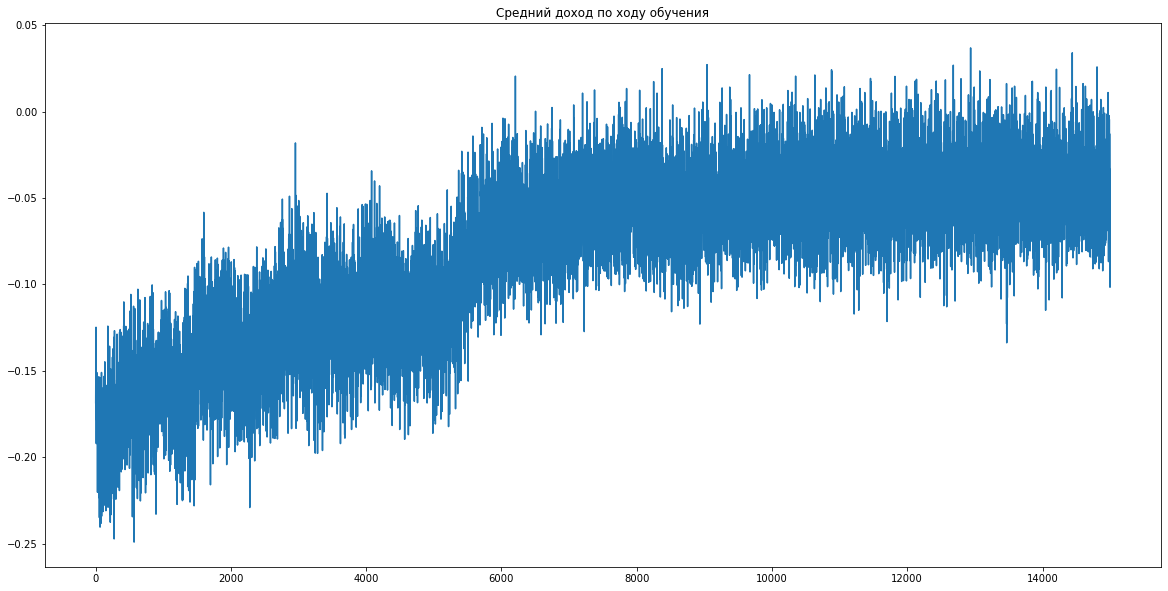

In [52]:
Q_learn_double_plot(epsilon=study_double.best_params["epsilon"], alpha=study_double.best_params["alpha"])

# Часть третья, в главной роли — Дастин Хоффман

#### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

In [53]:
def make_blackjack_counting_env():
    env = BlackjackCountingEnv(natural=True)
    return env

#### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [54]:
A = (0, 1, 2)
S = collect_states(make_blackjack_env, n_episods=10**5)
S = [(*S, cnt) for S, cnt in itertools.product(S, range(-44, 45))]

a_to_idx = {a: i for i, a in enumerate(A)}
idx_to_a = {i: a for i, a in enumerate(A)}
s_to_idx = {s: i for i, s in enumerate(S)}
idx_to_s = {i: s for i, s in enumerate(S)}

  0%|          | 0/100000 [00:00<?, ?it/s]

In [55]:
def Q_learn_counting(alpha=0.1, epsilon=0.05, n_episods=N_EPISODS, *args, **kwargs):
    Q = np.zeros((len(S), len(A)))
    
    for _ in trange(n_episods, *args, **kwargs):
        init = True
        done = False
        while not done:
            if init:
                env = make_blackjack_counting_env()
                observation = env.reset()
                s_idx = s_to_idx[observation]
                init = False
                continue
        
            if random.random() < epsilon:
                a_idx = np.random.choice(list(a_to_idx))
            else:
                a_idx = np.argmax(Q[s_idx])
            
            observation, reward, done, _ = env.step(idx_to_a[a_idx])
            s_next_idx = s_to_idx[observation]
            Q[s_idx, a_idx] += alpha * (reward + np.max(Q[s_next_idx]) - Q[s_idx, a_idx])
            s_idx = s_next_idx
        env.close()
    
    return Q

In [63]:
Q = Q_learn_counting(
    epsilon=study_double.best_params["epsilon"], 
    alpha=study_double.best_params["alpha"], 
    n_episods=2 * 10**6
)

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [64]:
def play_blackjack_counting_qlearning(Q):
    env = make_blackjack_counting_env()
    init = True
    done = False
    while not done:
        if init:
            observation = env.reset()
            init = False
            continue
        s_idx = s_to_idx[observation]
        a_idx = np.argmax(Q[s_idx])
        observation, reward, done, _ = env.step(idx_to_a[a_idx])
    env.close()
    return reward

In [65]:
monte_carlo_reward(play_blackjack_counting_qlearning, Q=Q)

  0%|          | 0/100000 [00:00<?, ?it/s]

-0.01394

In [66]:
def Q_learn_counting_plot(alpha=0.1, epsilon=0.05):
    Q = np.zeros((len(S), len(A)))
    n_episods = 15000
    avg_rewards = []
    for _ in trange(n_episods):
        init = True
        done = False
        while not done:
            if init:
                env = make_blackjack_counting_env()
                observation = env.reset()
                s_idx = s_to_idx[observation]
                init = False
                continue
        
            if random.random() < epsilon:
                a_idx = np.random.choice(list(a_to_idx))
            else:
                a_idx = np.argmax(Q[s_idx])
            
            observation, reward, done, _ = env.step(idx_to_a[a_idx])
            s_next_idx = s_to_idx[observation]
            Q[s_idx, a_idx] += alpha * (reward + np.max(Q[s_next_idx]) - Q[s_idx, a_idx])
            s_idx = s_next_idx
        r = monte_carlo_reward(play_blackjack_counting_qlearning, tqdm_disable=True, Q=Q, n_episods=3000)
        avg_rewards.append(r)
        env.close()
    
    plt.figure(figsize=(20, 10))
    plt.plot(range(1, n_episods + 1), avg_rewards)
    plt.title("Средний доход по ходу обучения")
    plt.show()

  0%|          | 0/15000 [00:00<?, ?it/s]

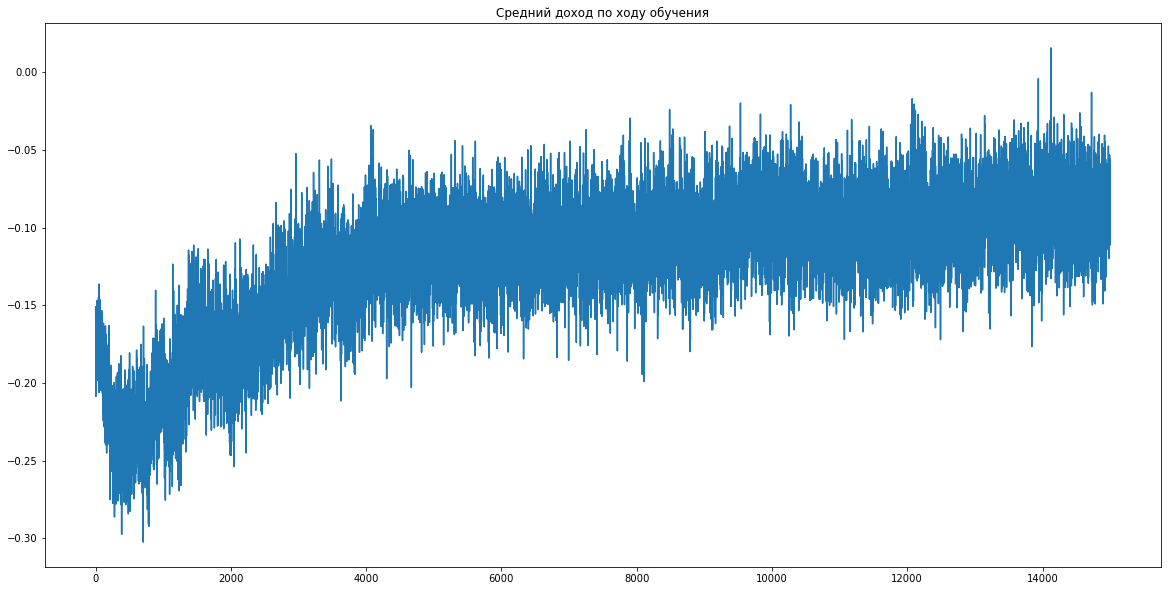

In [67]:
Q_learn_counting_plot(epsilon=study_double.best_params["epsilon"], alpha=study_double.best_params["alpha"])